In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import pandas as pd

Global seed set to 0


In [2]:
labelling = sc.read('../../scNT-seq/Neu_one_shot.h5ad')
splicing = sc.read('../../scNT-seq/neuron_splicing_4_11.h5ad')

In [3]:
splicing.obs = labelling.obs.loc[splicing.obs.index, :]
meta = pd.read_csv('../../scNT-seq/scnt_meta.csv', index_col=0)
splicing.obs = labelling.obs.loc[splicing.obs.index, :]
splicing = splicing[meta.index]
    
splicing.obs = meta
    
splicing.obsm['X_umap'] = np.concatenate((splicing.obs['umap_0'][:,None], splicing.obs['umap_1'][:,None]), axis=-1)
    
adata = splicing

scv.pp.filter_genes(adata, min_shared_counts=20)
ltv.utils.standard_clean_recipe(adata)

Filtered out 38268 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [4]:
model = ltv.models.VAE(observed=2000, latent_dim=30, encoder_hidden=35, 
                       zr_dim=1, h_dim=2,
                       use_velo_genes=True)

In [5]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                     epochs=50, name='scnt', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
140 velocity genes used
epoch 0, full loss 174.507, val loss 56.995, recon MSE 18.860, traj MSE 13.481, reg loss -2.670
epoch 1, full loss 121.668, val loss 33.032, recon MSE 16.327, traj MSE 11.004, reg loss -3.380
epoch 2, full loss 100.732, val loss 15.647, recon MSE 14.645, traj MSE 8.819, reg loss -4.087
epoch 3, full loss 98.244, val loss -1.702, recon MSE 13.695, traj MSE 8.067, reg loss -4.447
epoch 4, full loss 105.704, val loss -18.334, recon MSE 13.042, traj MSE 7.715, reg loss -4.862
epoch 5, full loss 124.849, val loss -32.841, recon MSE 12.054, traj MSE 7.466, reg loss -4.987
epoch 6, full loss 140.128, val loss -44.742, recon MSE 10.809, traj MSE 7.267, reg loss -4.894
epoch 7, full loss 165.596, val loss -54.801, recon MSE 9.918, traj MSE 7.193, reg loss -4.561
epoch 8, full loss 181.511, val loss -58.992, recon MSE 9.282, traj MSE 7.178, reg loss -4.553
epoch 9, full loss 169.125, val loss -60.959, reco

computing velocity graph (using 1/16 cores)


  0%|          | 0/3066 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


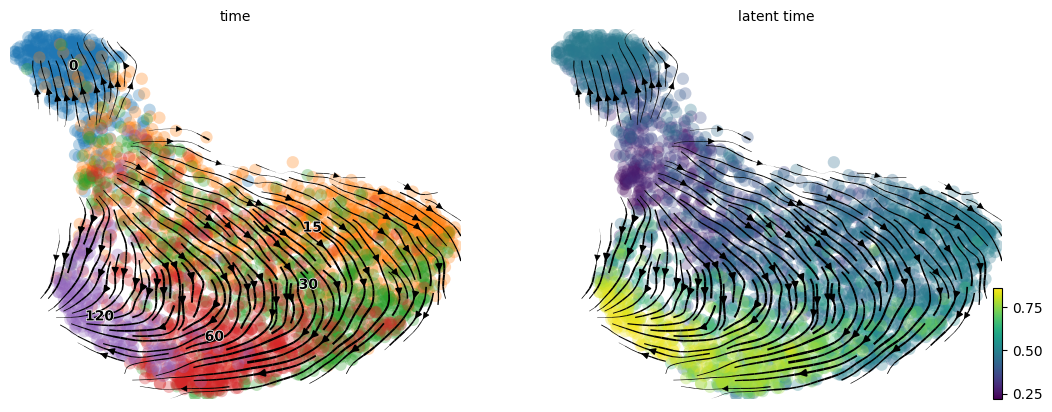

In [6]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True)
    
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['time', 'latent_time'])

In [7]:
scnt_edges = [
        ('0', '15'), 
        ('15', '30'),
        ('30', '60'),
        ('60','120')]

scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
scnt_pca = ltv.ev.cross_boundary_correctness(latent_adata,
            'time', 'spliced_velocity_pca', scnt_edges, x_emb='X_pca', 
              majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


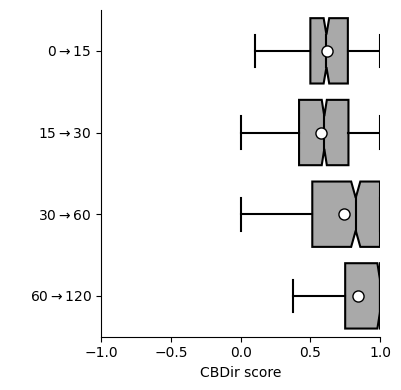

In [8]:
import matplotlib.pyplot as plt
ltv.pl.transition_scores(scnt_pca, raw=True)
plt.show()

In [9]:
# save fit
latent_adata.write('../benchmark/real_data/fits/scnt_latent_adata.h5ad')